In [11]:
import pandas as pd
from os.path import join
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import time,timedelta

sns.set()
sns.set_context('talk')
%matplotlib inline

In [109]:
timing_fpath = '../../data/raw/RA_records/timing.csv'
temps_dir = '../../data/raw/temp_sensors/main_experiment'

download_date = '20171008'
start_date = '2017-09-25'
full_fig_start_date = '2017-10-02'
end_date = '2017-10-06'

sensor_swap_date = '2017-10-03'
sensor_interval_early = 5
sensor_interval = 1

out_name = 'week2_temps'

# Get timing data

In [13]:
# Load csv containing start and stop times for session
timing_df = pd.read_csv(timing_fpath,index_col = [0,1,2], parse_dates = True,
            usecols=['Date','Session in day','Treatment group','Time entering room','Time ending modules'])
timing_df = timing_df.loc[start_date:end_date,:]

timing_df['start_time'] = pd.to_datetime(
    timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time entering room'])
timing_df['end_time'] = pd.to_datetime(
    timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time ending modules'])

# Impute end time from other concurrent session if not recorded
min_end_times = timing_df.groupby(level=[0,1])['end_time'].min()
max_start_times = timing_df.groupby(level=[0,1])['start_time'].max()
imputed_vals = pd.DataFrame({'min_end_time':min_end_times,
               'max_start_time':max_start_times},index = min_end_times.index)

imputed_vals = imputed_vals.append(imputed_vals)
imputed_vals['Treatment group'] = [0] * int(imputed_vals.shape[0] / 2) + [1] * int(imputed_vals.shape[0] / 2)
imputed_vals = imputed_vals.set_index('Treatment group',append=True)

timing_df = timing_df.join(imputed_vals)
timing_df.loc[:,'start_time'] = timing_df.loc[:,'start_time'].where(
    cond=timing_df.loc[:,'start_time'].notnull(), other=timing_df['max_start_time'])
timing_df.loc[:,'end_time'] = timing_df.loc[:,'end_time'].where(
    cond=timing_df.loc[:,'end_time'].notnull(), other=timing_df['min_end_time'])

timing_df = timing_df[['start_time','end_time']]

## Correct for not using 24 hour clock
for i in ['start_time','end_time']:
    bad_times_bool = (timing_df[i].dt.time < time(10)) & (timing_df.index.get_level_values(1) == 2)
    bad_times = timing_df.loc[bad_times_bool,i]
    new_times = bad_times + timedelta(hours=12)
    timing_df[i] = timing_df[i].where(bad_times_bool==False,other=new_times)

In [108]:
def make_full_plots(dfs,timing_df,out_name):

    experiment_dates = timing_df.index.get_level_values(0).unique()
    n_ex = len(experiment_dates)

    pretty_metrics = ['Temperature','RH']
    marker_colors = ['b','g']
    
    for mi,metric in enumerate(['T','RH']):

        fig,ax = plt.subplots(n_ex,2,figsize = (12,n_ex*6))
        if len(experiment_dates) == 1: ax = np.array([ax])
        
        for ei,e in enumerate(experiment_dates):
            if e < pd.to_datetime(sensor_swap_date):
                interval = sensor_interval_early
            else:
                interval = sensor_interval
                
            for gi,g in enumerate(['control','treatment']):
                
                this_ax = ax[ei,gi]
                first_ax = ax[0,0]
                second_ax = ax[0,1]
                last_ax = ax[n_ex-1,1]
                    
                for sesh in [1,2]:
                    
                    # skip if session was cancelled
                    this_group = (e,sesh,gi)
                    if this_group not in timing_df.index:
                        continue
                    times = timing_df.loc[this_group]

                    # produce values for behind partition and under RA desk
                    metric_df = dfs[g]['partition'].loc[times['start_time']:times['end_time'],metric]
                    metric_df = metric_df.reset_index(drop=True)
                    metric_df.index = metric_df.index*interval
                    metric_df.name = '{} Behind Partition, Session {}'.format(pretty_metrics[mi],sesh)
                    metric_df.plot(ax=this_ax,color=marker_colors[sesh-1])

                    metric_df = dfs[g]['RA'].loc[times['start_time']:times['end_time'],metric]
                    metric_df = metric_df.reset_index(drop=True)
                    metric_df.index = metric_df.index*interval
                    metric_df.name = '{} Under RA Desk, Session {}'.format(pretty_metrics[mi],sesh)
                    metric_df.plot(ax=this_ax,style=':',color=marker_colors[sesh-1])
                        
                this_ax.set_title('{}, {}'.format(e.date(), g.title()))
        
        last_ax.legend(loc='lower right')
        last_ax.set_xlabel('Minutes')
        ax[-1,0].set_xlabel('Minutes')
        
        # share axes down columns
        for i in [0,1]:
            axes_ylims = [ax[j,i].get_ylim() for j in range(n_ex)]
            min_y = min([j[0] for j in axes_ylims])
            max_y = max([j[1] for j in axes_ylims])
            [ax[j,i].set_ylim((min_y,max_y)) for j in range(n_ex)]
        ax[0,0].get_shared_y_axes().join(*list(ax[:,0]))
        ax[0,1].get_shared_y_axes().join(*list(ax[:,1]))
        
        fig.suptitle('{} {} Measurements'.format(
            site_str.title(),pretty_metrics[mi]),fontsize=18)
        fig.tight_layout()
        fig.subplots_adjust(top=.95)
        fig.savefig('../../results/figures/main_experiment/{}_{}.png'.format(out_name,metric))

    return None


In [99]:
def calc_means(dfs,timing_df):
    experiment_dates = timing_df.index.get_level_values(0).unique()
    n_ex = len(experiment_dates)

    pretty_metrics = ['Temperature','RH']
    marker_colors = ['b','g']
    
    means = {}
    
    for gi,g in enumerate(['control','treatment']):
        means[g] = {}
        
        for m in ['T','RH']:
            means[g][m] = {}
            for area in ['partition','RA']:
                means[g][m][area] = []
            
        for e in experiment_dates:
            for s in [1,2]:

                # skip if session was cancelled
                this_group = (e,s,gi)
                if this_group not in timing_df.index:
                    continue
                times = timing_df.loc[this_group]

                # calc_means for behind partition and under RA desk
                for area in ['partition','RA']:
                    metric_df = dfs[g][area].loc[times['start_time']:times['end_time'],:]
                    this_means = metric_df.mean()
                    for m in ['T','RH']:
                        means[g][m][area].append(this_means[m])
            
    return means

In [114]:
def plot_means(means):

    fig,ax = plt.subplots(1,2,figsize = (12,6))

    for ix,i in enumerate(['control','treatment']):
        mean_temps = pd.DataFrame(means[i]['T'])
        mean_temps.plot(ax=ax[ix])
        ax[ix].set_title('Mean temps per experiment, {}'.format(i.title()))
        ax[ix].legend(loc='upper right')

    control_means = means['control']['T']
    mean_of_means_control = np.nansum(np.array(control_means['RA'] + control_means['partition'])) / (2*len(control_means['RA']))
    last_wk_mean_of_means_control = np.nansum(np.array(
        control_means['RA'][-10:] + control_means['partition'][-10:])) / 20
    
    ## do mean of means for treatment using only partition sensor, since clear bias
    tx_means = means['treatment']['T']
    mean_of_means_tx = np.nansum(np.array(tx_means['RA'])) / len(tx_means['RA'])
    last_wk_mean_of_means_tx = np.nansum(np.array(tx_means['RA'][-10:])) / 10

    ax[0].text(x = .5,y=.15,s='Mean of means (overall): {:.2f}'.format(mean_of_means_control),
               fontsize=14,transform = ax[0].transAxes,horizontalalignment='center')
    ax[0].text(x = .5,y=.05,s='Mean of means (last wk): {:.2f}'.format(last_wk_mean_of_means_control),
               fontsize=14,transform = ax[0].transAxes,horizontalalignment='center')
    ax[1].text(x = .5,y=.15,s='Mean of means (RA sensor only, overall): {:.2f}'.format(mean_of_means_tx),
               fontsize=14,transform = ax[1].transAxes,horizontalalignment='center')
    ax[1].text(x = .5,y=.05,s='Mean of means (RA sensor only, last wk): {:.2f}'.format(last_wk_mean_of_means_tx),
               fontsize=14,transform = ax[1].transAxes,horizontalalignment='center')

    fig.savefig('../../results/figures/main_experiment/{}_means.png'.format(out_name))
    
    return None

# Plot

In [66]:
## Load DFs
dfs = {'treatment':{},
      'control':{}}
for gi,g in enumerate(['control','treatment']):
    dfs[g]['partition_early'] = pd.read_excel(join(temps_dir,'20171002_{}_partition.xls'.format(g)),
                      sheetname='Records',parse_dates=True,index_col=0).loc[:pd.to_datetime(sensor_swap_date),:]
    dfs[g]['partition_early'].columns=['T','RH']
    dfs[g]['partition_early'].index.name='time'
    
    dfs[g]['partition'] = pd.read_csv(join(temps_dir,'{}_{}_partition.csv'.format(download_date,g)),usecols=[1,2,3],header=1,
               index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
    dfs[g]['partition'].columns=['T','RH']
    dfs[g]['partition'].index.name='time'
    
    dfs[g]['RA_early'] = pd.read_excel(join(temps_dir,'20171002_{}_RA.xls'.format(g)),
                      sheetname='Data Table',parse_dates=True,index_col=1,header=21).iloc[:,1].loc[:pd.to_datetime(sensor_swap_date)]
    dfs[g]['RA_early'].name = 'T'
    dfs[g]['RA_early'] = pd.DataFrame(dfs[g]['RA_early'])
    dfs[g]['RA_early']['RH'] = np.nan
    dfs[g]['RA_early'].columns = ['T','RH']
    dfs[g]['RA_early'].index.name='time'

    dfs[g]['RA'] = pd.read_csv(join(temps_dir,'{}_{}_RA.csv'.format(download_date,g)),usecols=[1,2,3],header=1,
               index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
    dfs[g]['RA'].columns=['T','RH']
    dfs[g]['RA'].index.name='time'
    
    # append early sensors and HOBO sensors from when we swapped
    dfs[g]['RA'] = dfs[g]['RA_early'].append(dfs[g]['RA'])
    dfs[g]['partition'] = dfs[g]['partition_early'].append(dfs[g]['partition'])
    del dfs[g]['partition_early'],dfs[g]['RA_early']

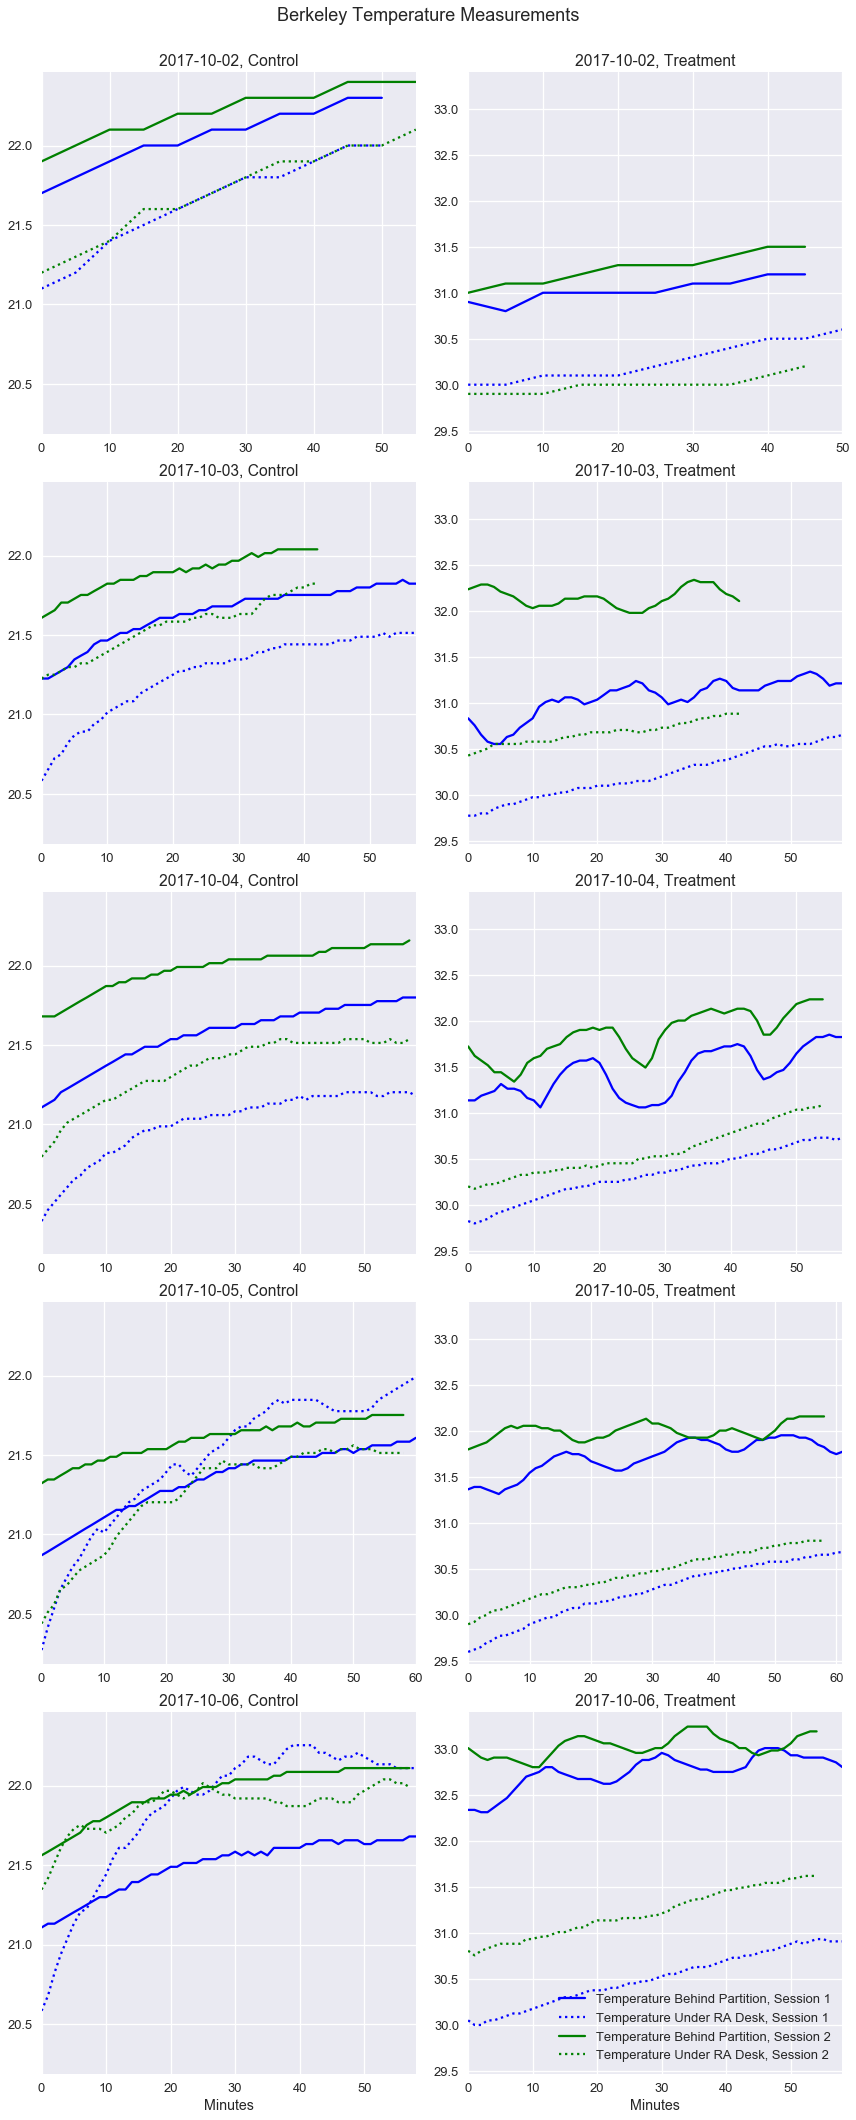

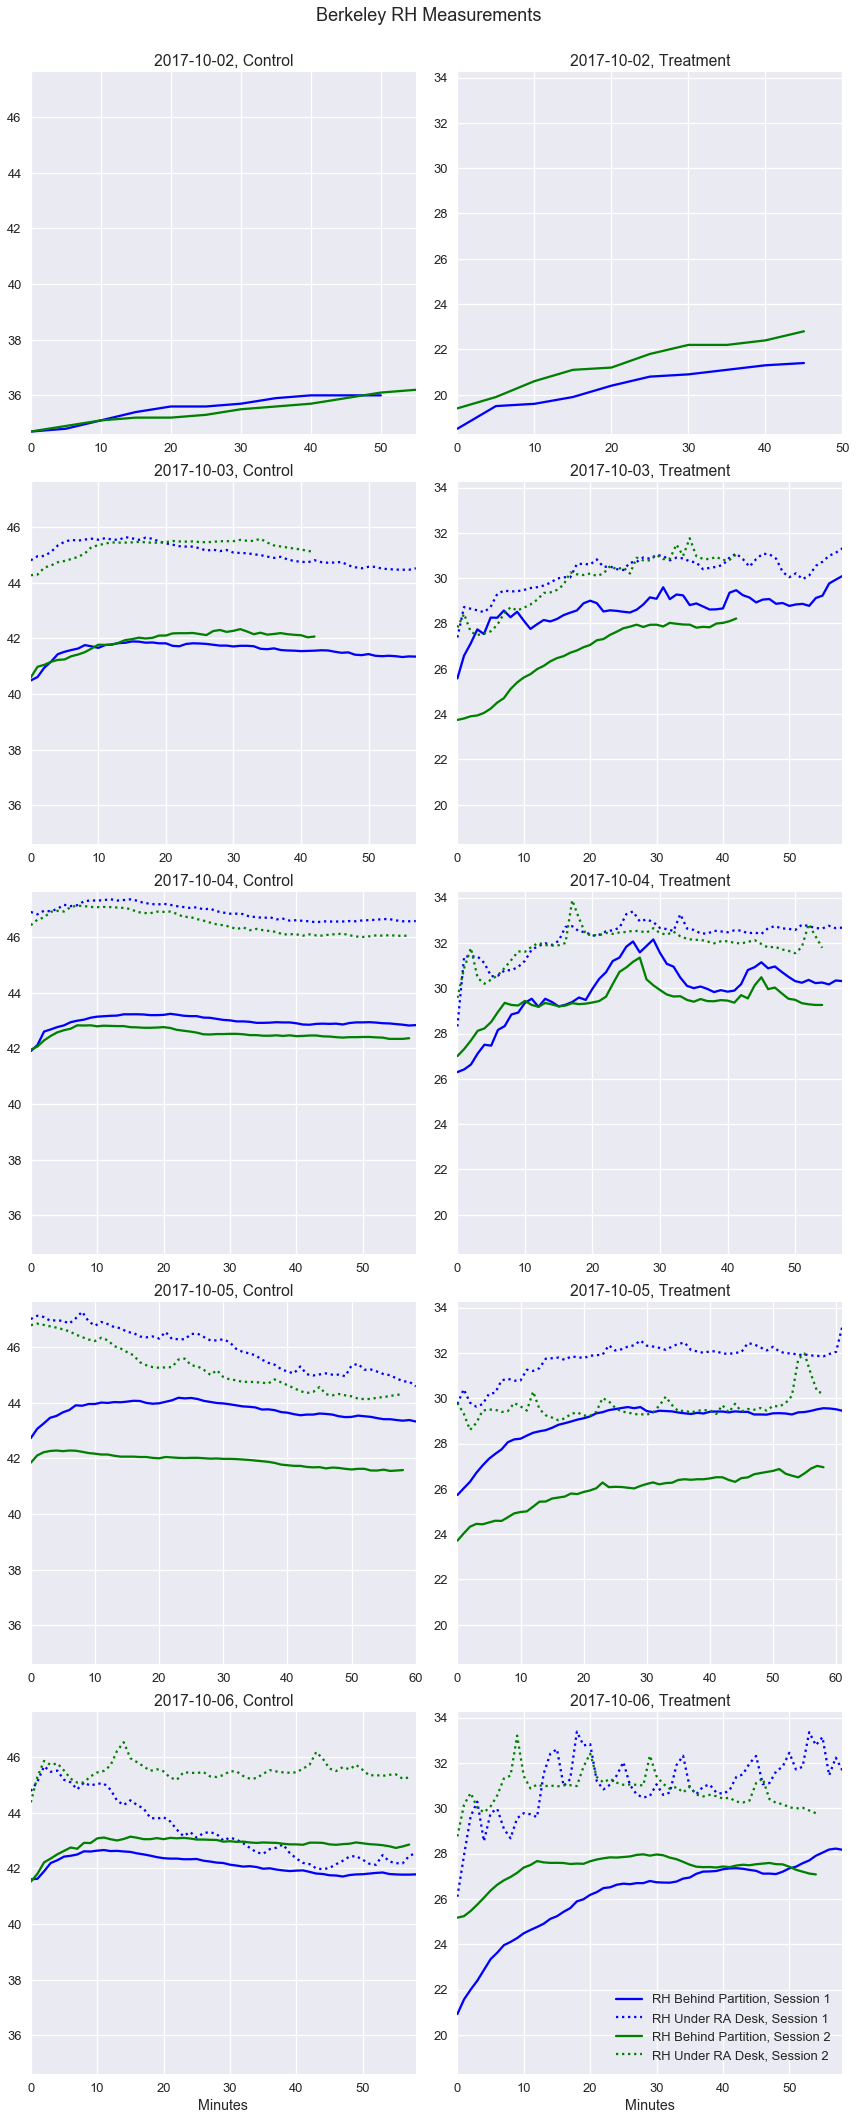

In [79]:
# make full plots
full_fig_timing = timing_df.loc[full_fig_start_date:end_date,:]
make_full_plots(dfs,full_fig_timing,out_name)

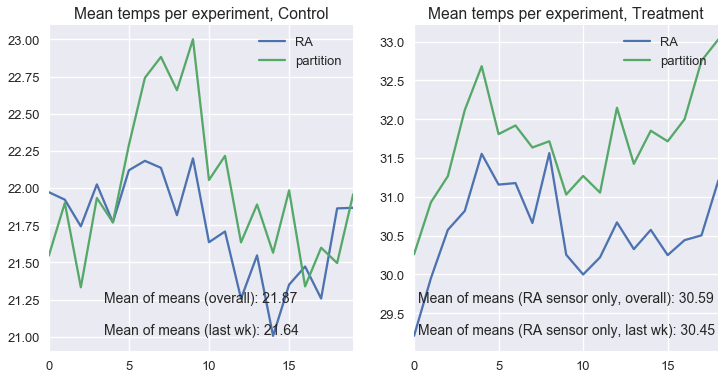

In [116]:
## get means over full experiment
means = calc_means(dfs,timing_df)

## get means over this week
means_this_week = calc_means(dfs,full_fig_timing)

## Plot
plot_means(means)